# 1. 데이터 로드하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml

In [2]:
mnist=fetch_openml('mnist_784',version=1, cache=True)

In [3]:
mnist.data[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [4]:
mnist.target[0]

'5'

In [30]:
mnist.target=mnist.target.astype(np.int8)

In [38]:
X=mnist.data/255
y=mnist.target

In [33]:
X[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [34]:
y[0]

5

이 이미지 데이터의 레이블은 5이다


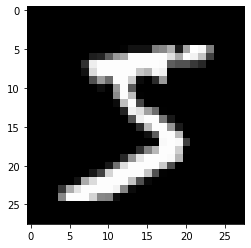

In [35]:
plt.imshow(X[0].reshape(28,28), cmap='gray')
print('이 이미지 데이터의 레이블은 {:.0f}이다'.format(y[0]))

# 2. 훈련 데이터와 테스트 데이터의 분리

In [36]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=1/7, random_state=0)

X_train=torch.Tensor(X_train)
X_test=torch.Tensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

ds_train=TensorDataset(X_train, y_train)
ds_test=TensorDataset(X_test, y_test)

loader_train=DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test=DataLoader(ds_test, batch_size=64, shuffle=False)

# 3. 다층 퍼셉트론

In [53]:
from torch import nn
model=nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu', nn.ReLU())
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [54]:
from torch import optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)

In [59]:
def train(epoch):
    model.train() # 신경망을 학습모드로 전환
    
    for data, targets in loader_train:
        optimizer.zero_grad()
        outputs=model(data) # 데이터를 입력하고 출력을 계산
        loss=loss_fn(outputs, targets) # 출력과 훈련 데이터 정답간의 오차 계산
        loss.backward() # 오차를 역전파 계산
        optimizer.step() # 역전파 계산한 값으로 가중치를 수정
        
    print("epoch{} : 완료\n".format(epoch));

In [60]:
def test():
    model.eval() # 신경망을 추론 모드로 전환
    correct=0
    
    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad(): # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:
            
            outputs=model(data) # 데이터를 입력하고 출력을 계산
            
            # 추론 계산
            _, predicted=torch.max(outputs.data, 1) # 확률이 가장 높은 레이블이 무엇인지 계산
            correct+=predicted.eq(targets.data.view_as(predicted)).sum() # 정답과 일치한 경우 정답 카운트를 증가
            
    # 정확도 출력
    data_num=len(loader_test.dataset) # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100.*correct/data_num))

In [63]:
test()


테스트 데이터에서 예측 정확도: 1059/10000 (11%)



In [64]:
for epoch in range(3):
    train(epoch)
    
test()

epoch0 : 완료

epoch1 : 완료

epoch2 : 완료


테스트 데이터에서 예측 정확도: 9631/10000 (96%)



예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다.


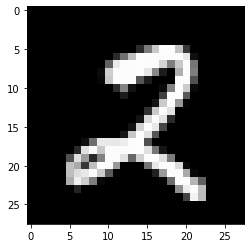

In [65]:
index=2018

model.eval() # 신경망을 추론 모드로 전환
data=X_test[index]
output=model(data)
_, predicted=torch.max(output.data, 0) # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show=(X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다.".format(y_test[index]))